In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import wandb
import pandas as pd
import statsmodels.graphics.tsaplots
api = wandb.Api()
print(os.getcwd())
wandb_id = 'r0v8x13s'
wandb_project = 'the_patpat/LibMTL-examples_multi_mnist'

/home/pasch/repos/LibMTL


In [160]:
wandb_ids = [run.id for run in api.runs(wandb_project)]
wandb_ids = ['upk3s608', '2vmd85u8', '8nz7syjj']

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
def load_run(wandb_id, project='multi_mnist'):
    data = np.load(f'examples/{project}/gradients_{wandb_id}.npz')
    run = api.run(f'the_patpat/LibMTL-examples_{project}/{wandb_id}')
    run_hist = run.history()
    name = run.name
    gradients = data['arr_0']
    return name, run_hist, gradients

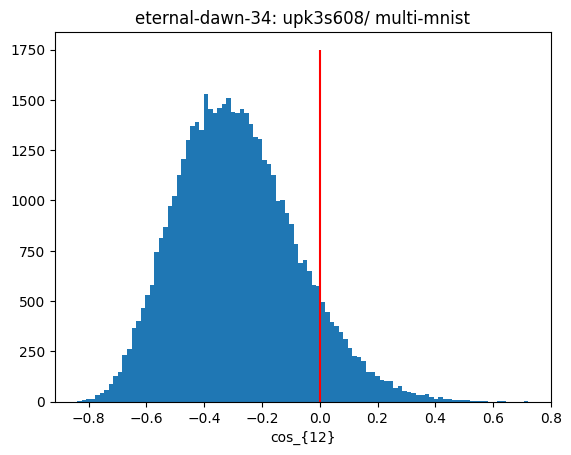

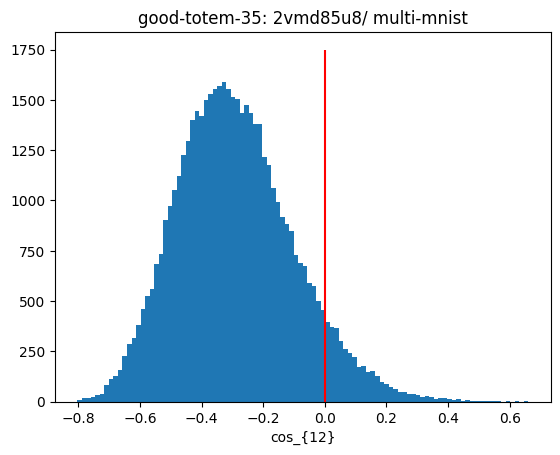

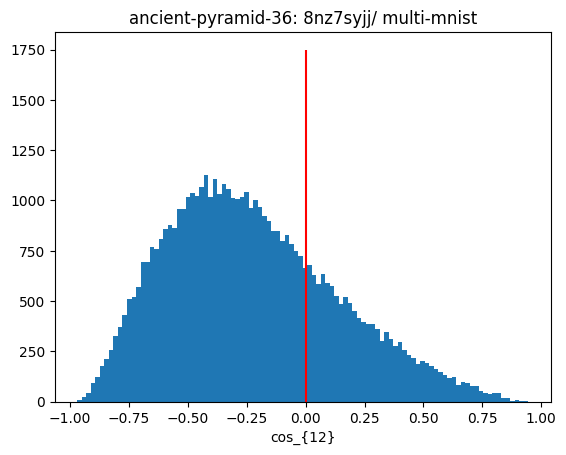

In [161]:
for wandb_id in wandb_ids:
    try:
        name, run, gradients = load_run(wandb_id)
        plt.figure()
        plt.hist(gradients[:, :, 0, 1].flatten(), bins=100)
        plt.title(f'{name}: {wandb_id}/ multi-mnist')
        plt.xlabel('cos_{12}')
        plt.vlines([0.0], [0], [1750], 'r')
    except FileNotFoundError:
        print(f'gradient file for {wandb_id} not found')

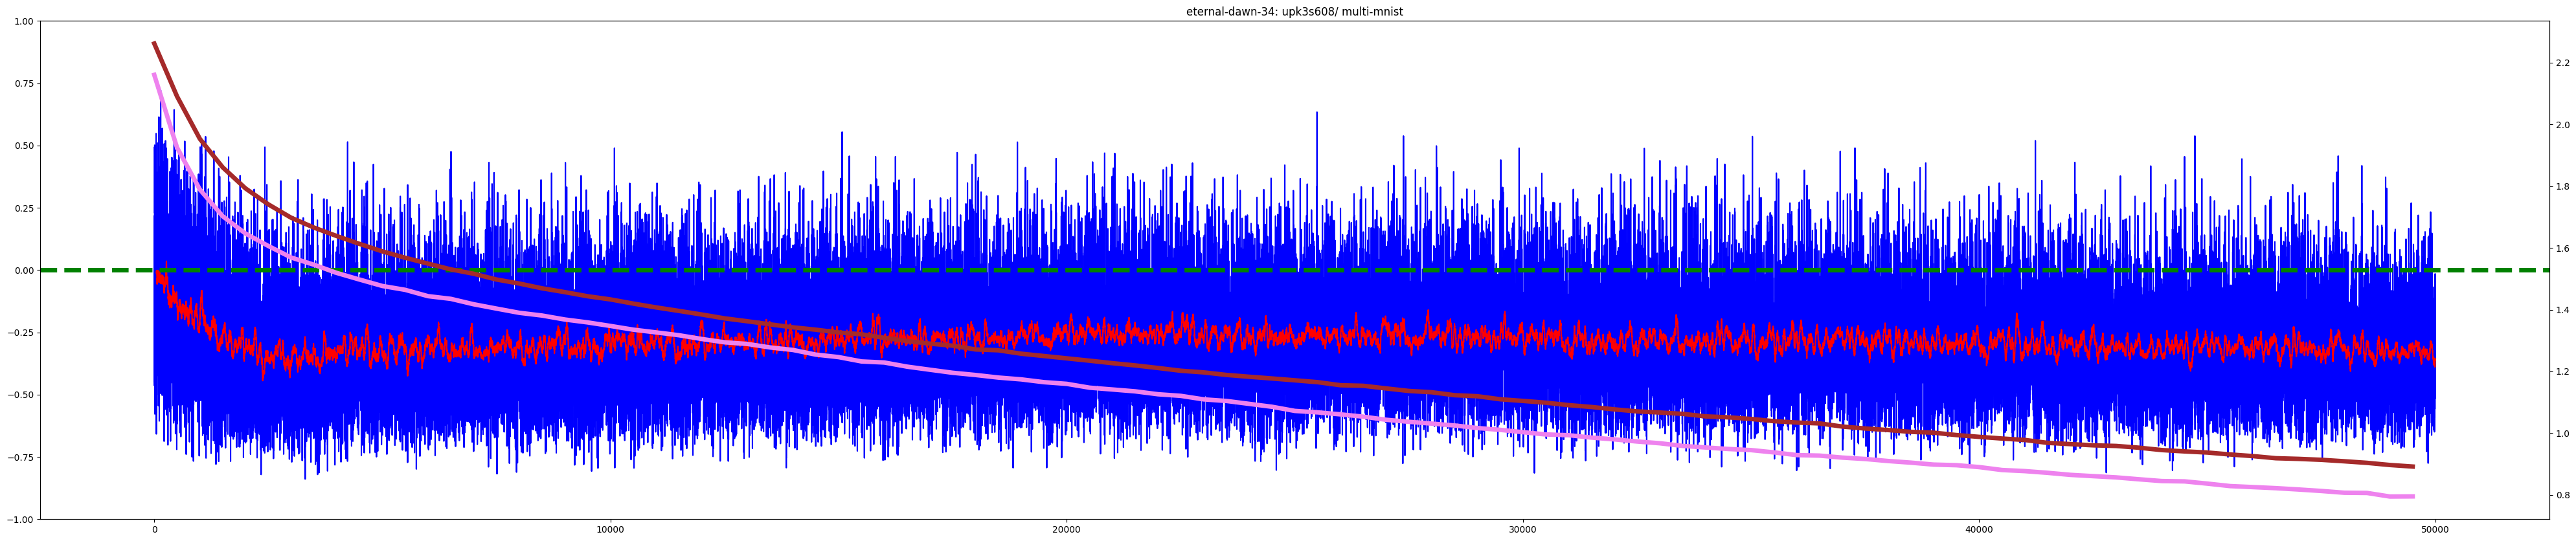

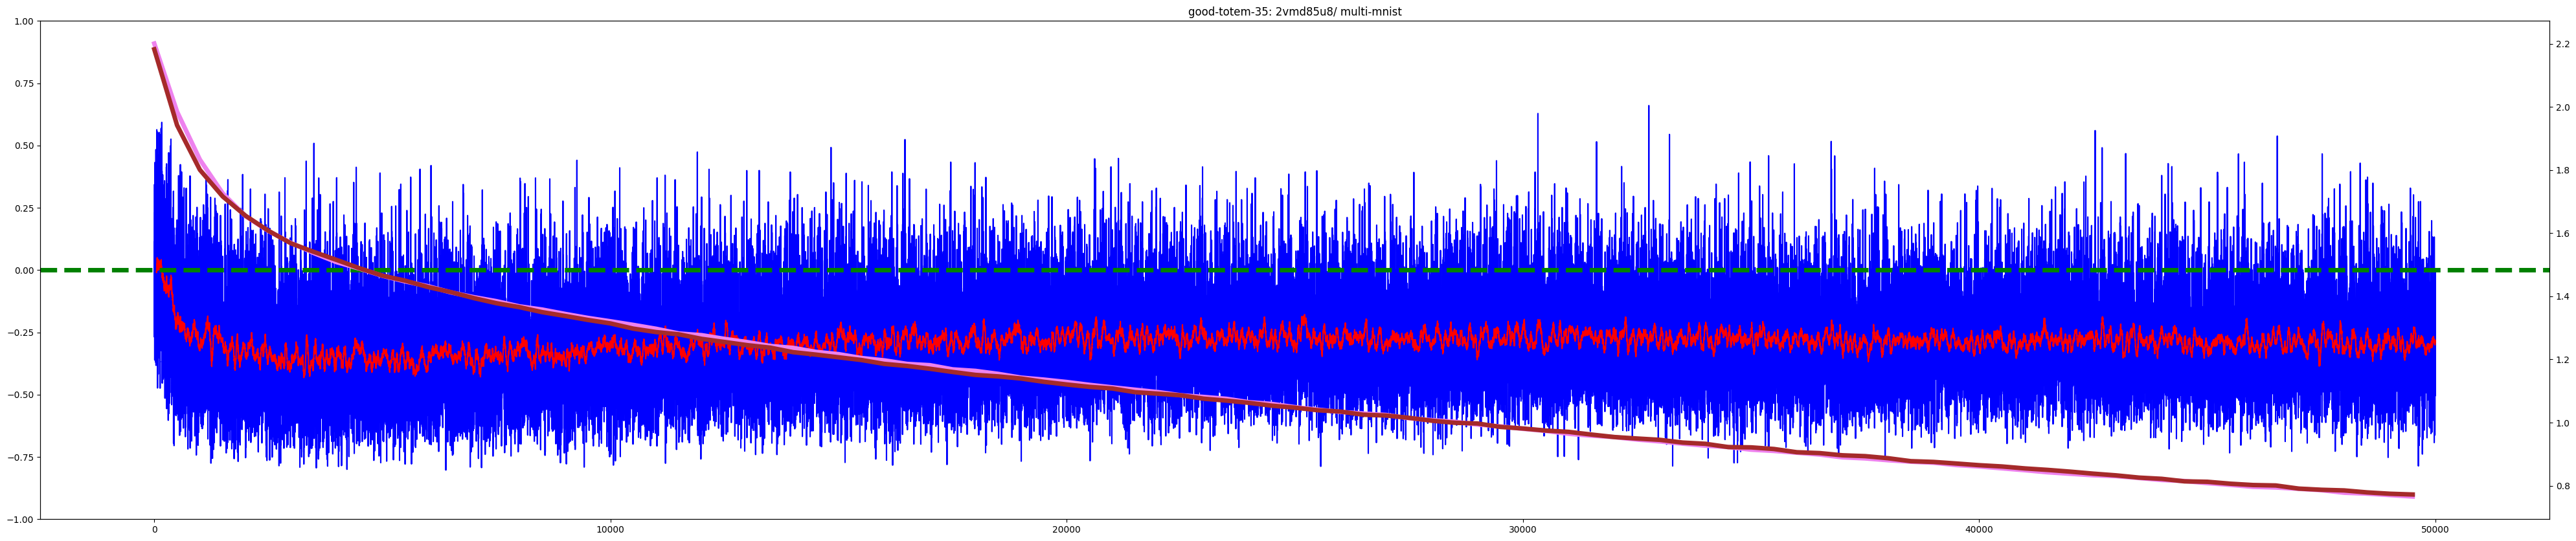

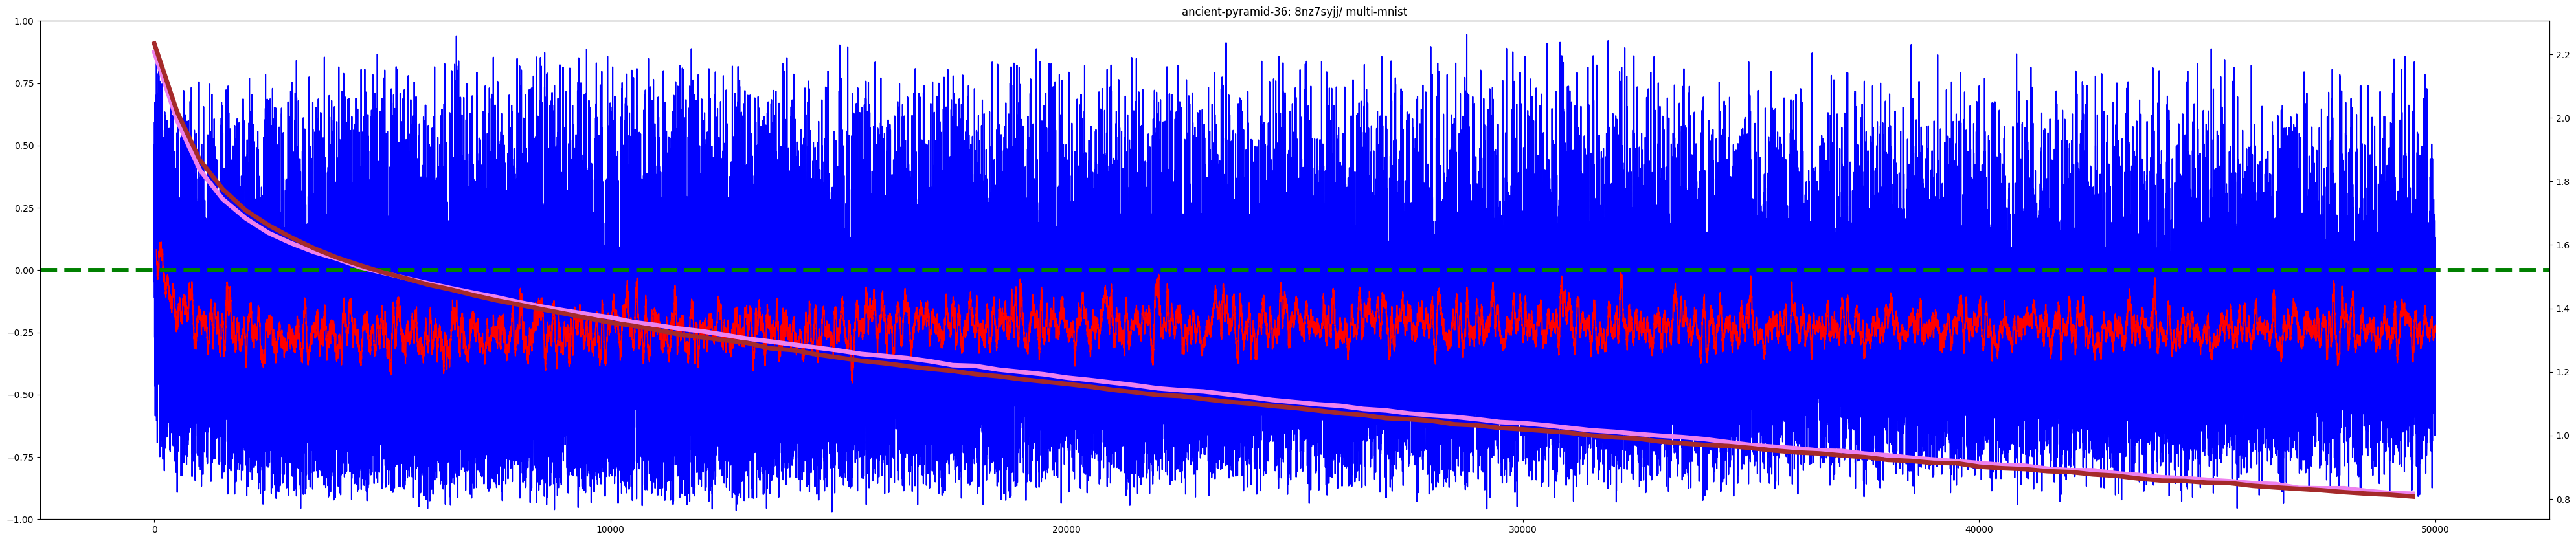

In [162]:
for wandb_id in wandb_ids:
    name, run_hist, gradients = load_run(wandb_id)
    
    # Cos similarities and filtered version
    plt.figure(figsize=(50,10))
    plt.title(f'{name}: {wandb_id}/ multi-mnist')
    plt.plot(gradients[:, :, 0, 1].flatten(), 'b')
    plt.ylim(-1,1)
    pd.Series(gradients[:, :, 0,1].flatten()).rolling(50).mean().plot(color='r')
    plt.axhline(0, 0, 1.0, color='green', linestyle='dashed', linewidth=5)
    
    # Losses
    plt.twinx()
    plt.plot(np.arange(0,50000, 50000/100), run_hist['losses.train.L'].dropna(), color='violet', linewidth=5)
    plt.plot(np.arange(0,50000, 50000/100), run_hist['losses.train.R'].dropna(), color='brown', linewidth=5)

upk3s608  upk3s608.L  upk3s608.R  2vmd85u8  2vmd85u8.L  \
upk3s608    1.000000    0.468555    0.424402  0.763971    0.469680   
upk3s608.L  0.468555    1.000000    0.992074  0.466277    0.997451   
upk3s608.R  0.424402    0.992074    1.000000  0.439147    0.995666   
2vmd85u8    0.763971    0.466277    0.439147  1.000000    0.473188   
2vmd85u8.L  0.469680    0.997451    0.995666  0.473188    1.000000   
2vmd85u8.R  0.439726    0.995516    0.997413  0.441047    0.996454   
8nz7syjj    0.557017    0.189541    0.189277  0.580325    0.199818   
8nz7syjj.L  0.478753    0.996774    0.993092  0.474055    0.998263   
8nz7syjj.R  0.430828    0.995580    0.997785  0.444362    0.997091   

            2vmd85u8.R  8nz7syjj  8nz7syjj.L  8nz7syjj.R  
upk3s608      0.439726  0.557017    0.478753    0.430828  
upk3s608.L    0.995516  0.189541    0.996774    0.995580  
upk3s608.R    0.997413  0.189277    0.993092    0.997785  
2vmd85u8      0.441047  0.580325    0.474055    0.444362  
2vmd85u8.L    0.996454  0.199818    0.998263    0.997091  
2vmd85u8.R    1.000000  0.186711    0.996535    0.998919  
8nz7syjj      0.186711  1.000000    0.201948    0.184768  
8nz7syjj.L    0.996535  0.201948    1.000000    0.996318  
8nz7syjj.R    0.998919  0.184768    0.996318    1.000000

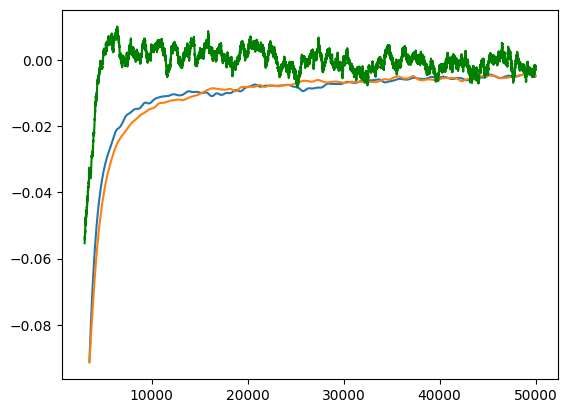

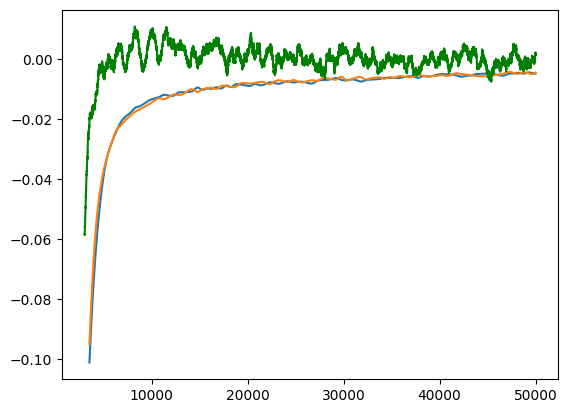

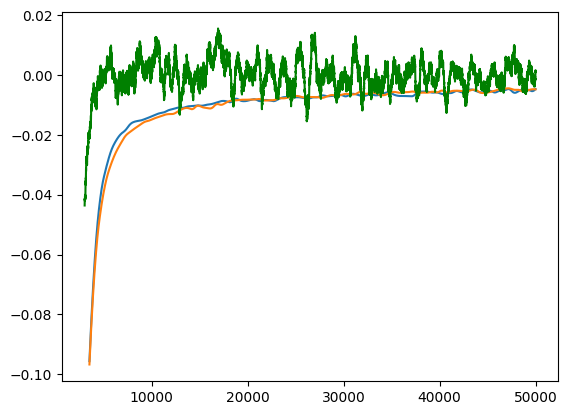

In [163]:
gradient_df = pd.DataFrame()
loss_df = pd.DataFrame()
df = pd.DataFrame()
for wandb_id in wandb_ids:
    name, run_hist, gradients = load_run(wandb_id)
    
    # Gradients and losses as dataframe
    num_epochs = gradients.shape[0]
    num_batch = gradients.shape[1]
    gradient_df = pd.DataFrame()
    loss_df = pd.DataFrame()
    gradient_df[wandb_id] = pd.Series(gradients[:, :, 0, 1].flatten())
    loss_df[f'{wandb_id}.L'] = run_hist['losses.train.L'].dropna()
    loss_df[f'{wandb_id}.R'] = run_hist['losses.train.R'].dropna()
    loss_df = loss_df.reset_index().drop('index', axis=1)
    loss_df.index = np.arange(num_batch-1, num_epochs*num_batch, num_batch)
    
    #Put into one dataframe, with interpolated values for loss
    df = pd.concat([df, gradient_df, loss_df], axis=1)
    df = df.interpolate('linear')
            
    # Plot first order difference of train loss for each task
    # np.interp(np.arange())
    plt.figure()
    plt.plot(df[f'{wandb_id}.L'].dropna().rolling(2500).mean().diff(periods=num_batch))
    plt.plot(df[f'{wandb_id}.R'].dropna().rolling(2500).mean().diff(periods=num_batch))
    # Plot mean cosine similarity per epoch 1st order difference
    plt.plot(df[wandb_id].rolling(2500).mean().diff(periods=num_batch), 'g')
    # plt.plot(gradients.mean(axis=1)[:, 0, 1], 'g')

    # Calculate r2 between first-order difference of loss and mean gradient
    # r2 = np.corrcoef(df[f'{wandb_id}.L'].dropna().rolling(2500).mean().diff(periods=num_batch).dropna(), df[wandb_id].rolling(2500).mean().diff(periods=num_batch).dropna() )
    # print(r2)

    # plt.title(f'{name}/{wandb_id}, r2: {float(r2[0, 1]):.3f}')

r2 = df.rolling(2500).mean().diff(periods=num_batch).corr()
r2

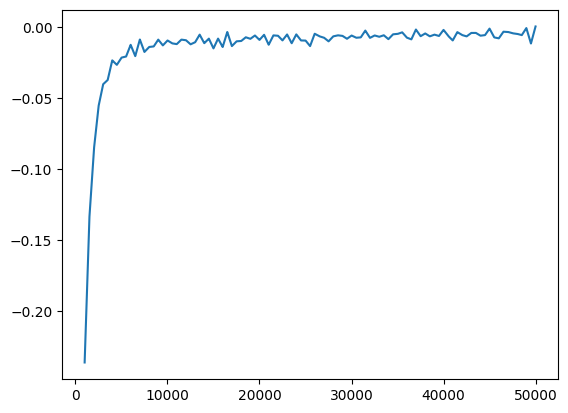

In [84]:
plt.plot(df['upk3s608.L'].diff(periods=500))

In [63]:
loss_df.index = np.arange(num_batch-1, (num_epochs)*num_batch, num_batch)

In [64]:
loss_df

upk3s608.L  upk3s608.R  2vmd85u8.L  2vmd85u8.R  8nz7syjj.L  8nz7syjj.R
499      2.160619    2.262134    2.200994    2.182768    2.207413    2.234073
999      1.924705    2.090620    1.985074    1.942072    1.991980    2.019014
1499     1.789094    1.953185    1.833124    1.800784    1.835778    1.867056
1999     1.702675    1.861075    1.726408    1.716358    1.744219    1.775711
2499     1.646641    1.792809    1.654003    1.655383    1.683930    1.709431
...           ...         ...         ...         ...         ...         ...
47999    0.812677    0.913578    0.785715    0.787029    0.833724    0.827459
48499    0.806960    0.908899    0.777590    0.784944    0.834028    0.821458
48999    0.806245    0.903787    0.774835    0.778710    0.825431    0.816688
49499    0.794687    0.896826    0.770262    0.774441    0.818921    0.813373
49999    0.795100    0.891804    0.765605    0.772024    0.816704    0.807756

[100 rows x 6 columns]

In [98]:
df[f'{wandb_id}.L'].diff(periods=num_batch).dropna()

999     -0.215433
1000    -0.215315
1001    -0.215196
1002    -0.215078
1003    -0.214959
           ...   
49995   -0.002251
49996   -0.002243
49997   -0.002234
49998   -0.002226
49999   -0.002217
Name: 8nz7syjj.L, Length: 49001, dtype: float64

In [68]:
pd.concat([gradient_df, loss_df], axis=1).interpolate(method='linear')

upk3s608  2vmd85u8  8nz7syjj  upk3s608.L  upk3s608.R  2vmd85u8.L  \
0     -0.349230  0.100342  0.408762         NaN         NaN         NaN   
1     -0.433978 -0.103907  0.501419         NaN         NaN         NaN   
2      0.041112 -0.033228  0.201920         NaN         NaN         NaN   
3     -0.447281 -0.189527 -0.046941         NaN         NaN         NaN   
4      0.218056 -0.000742  0.198793         NaN         NaN         NaN   
...         ...       ...       ...         ...         ...         ...   
49995 -0.449425 -0.008296 -0.150023    0.795096    0.891844    0.765642   
49996 -0.513742 -0.107052 -0.165044    0.795097    0.891834    0.765633   
49997 -0.360548 -0.224280 -0.121750    0.795098    0.891824    0.765624   
49998 -0.431362 -0.415922 -0.298157    0.795099    0.891814    0.765614   
49999 -0.372238 -0.365030 -0.521719    0.795100    0.891804    0.765605   

       2vmd85u8.R  8nz7syjj.L  8nz7syjj.R  
0             NaN         NaN         NaN  
1             NaN         NaN         NaN  
2             NaN         NaN         NaN  
3             NaN         NaN         NaN  
4             NaN         NaN         NaN  
...           ...         ...         ...  
49995    0.772043    0.816722    0.807801  
49996    0.772038    0.816718    0.807790  
49997    0.772034    0.816713    0.807779  
49998    0.772029    0.816709    0.807767  
49999    0.772024    0.816704    0.807756  

[50000 rows x 9 columns]

# NYU runs
NYUv2 has three tasks - semantic segmentation, surface normal estimation and monocular depth estimation
We have to consider gradients
$$
C(n,r) = \begin{pmatrix}n\\ r\end{pmatrix} = \frac{n!}{(r!(n-r!))}
$$
with $n=3$ being the number of objects (tasks) and $r$ being the number of samples (2, two gradients)

**NB**: Right now just considering segmentation and depth, as it makes the setup more comparable to cityscapes

In [138]:
wandb_project = 'the_patpat/LibMTL-examples_nyu'
# wandb_ids = [run.id for run in api.runs(wandb_project)]
wandb_ids = ['frew28mz', 'frjdq2uw', 'cdfv66vp']

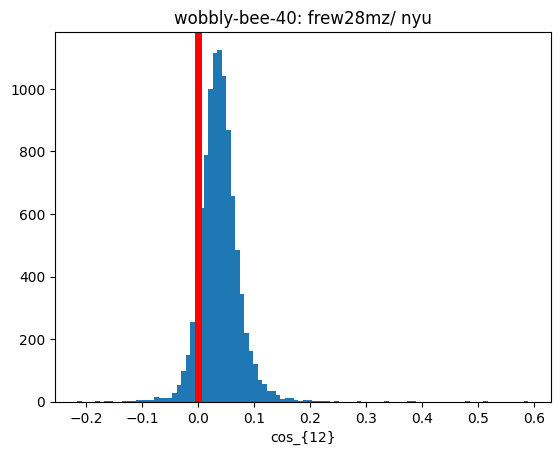

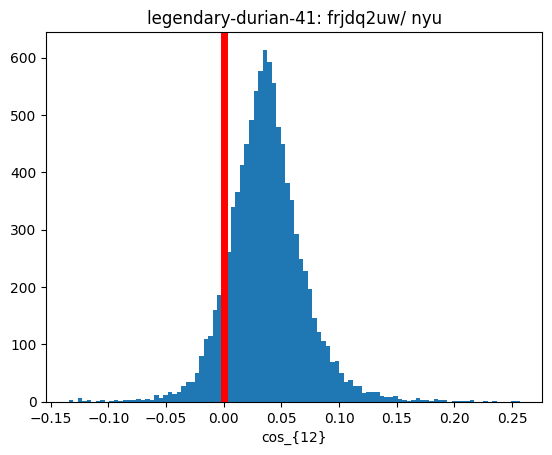

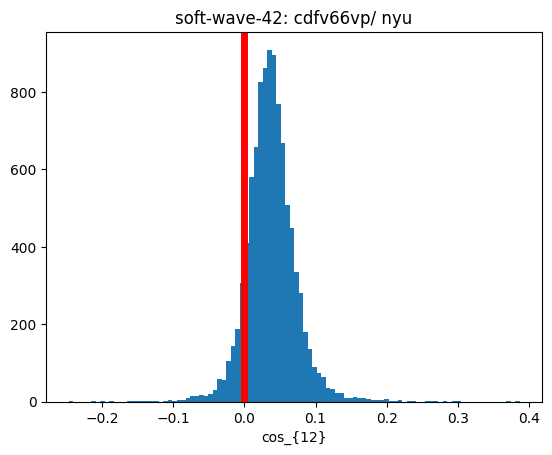

In [139]:
for wandb_id in wandb_ids:
    try:
        name, run, gradients = load_run(wandb_id, 'nyu')
        plt.figure()
        plt.hist(gradients[:, :, 0, 1].flatten(), bins=100)
        plt.title(f'{name}: {wandb_id}/ nyu')
        plt.xlabel('cos_{12}')
        plt.axvline(0, 0, 1, color='r', linewidth=5)
    except FileNotFoundError:
        print(f'gradient file for {wandb_id} not found')

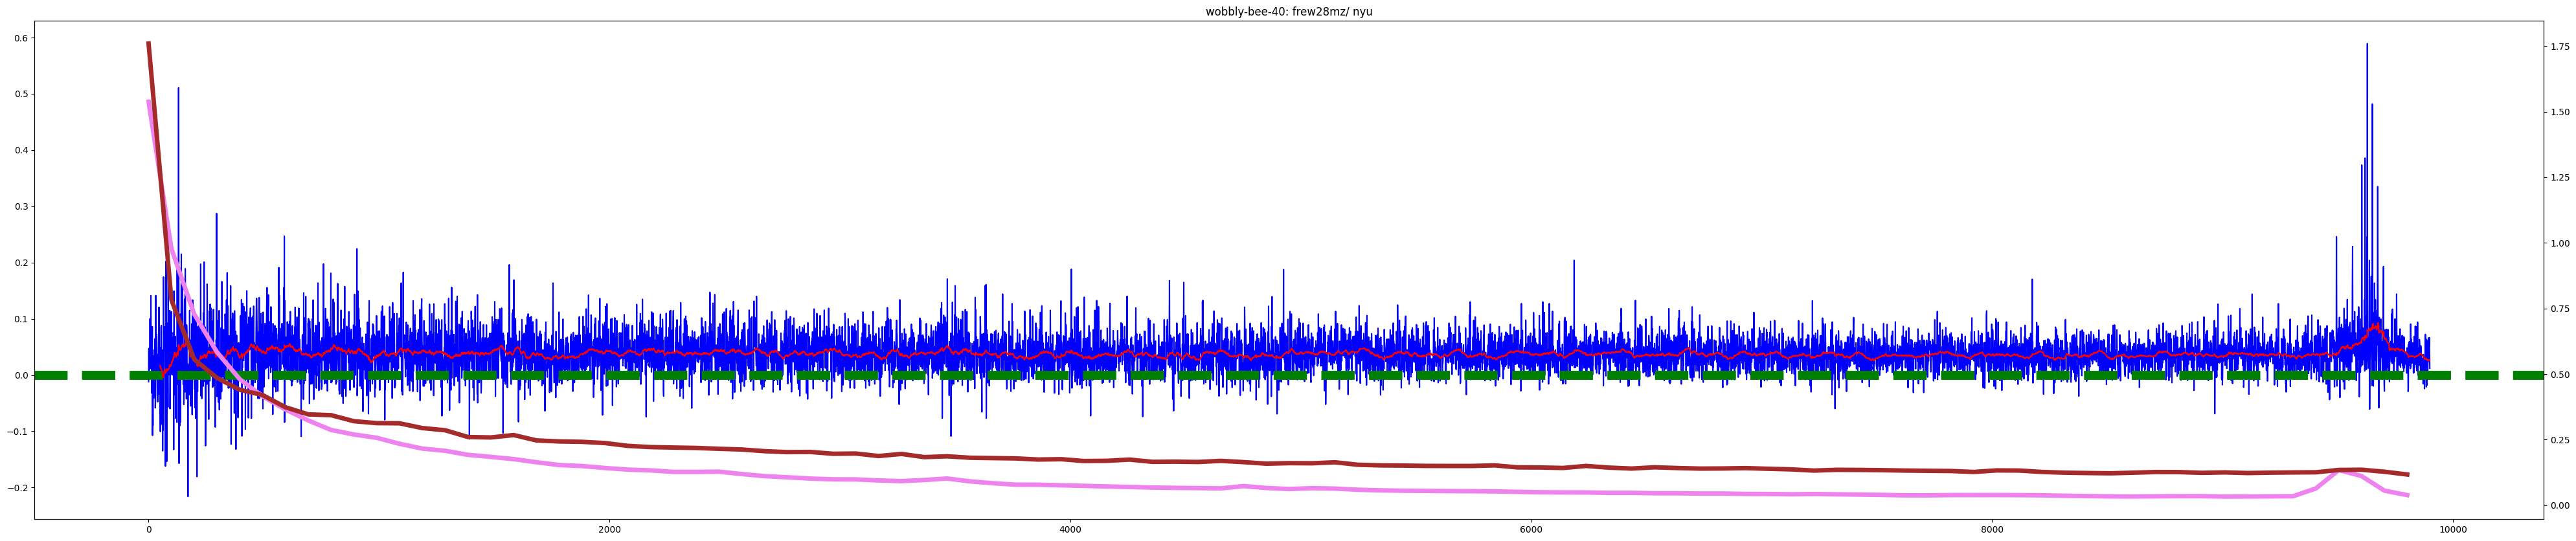

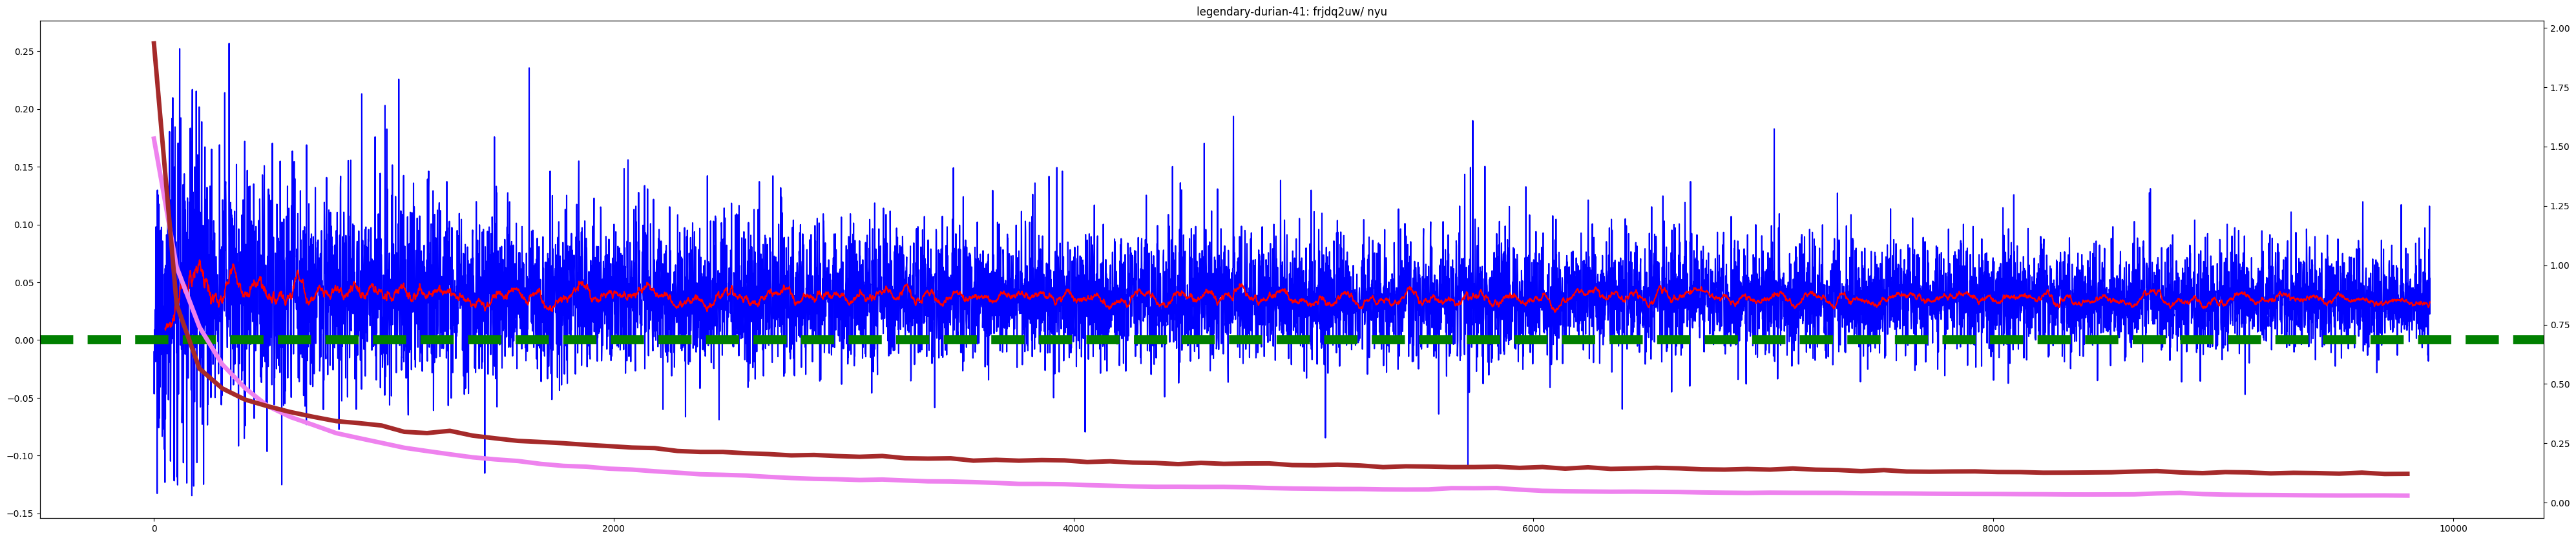

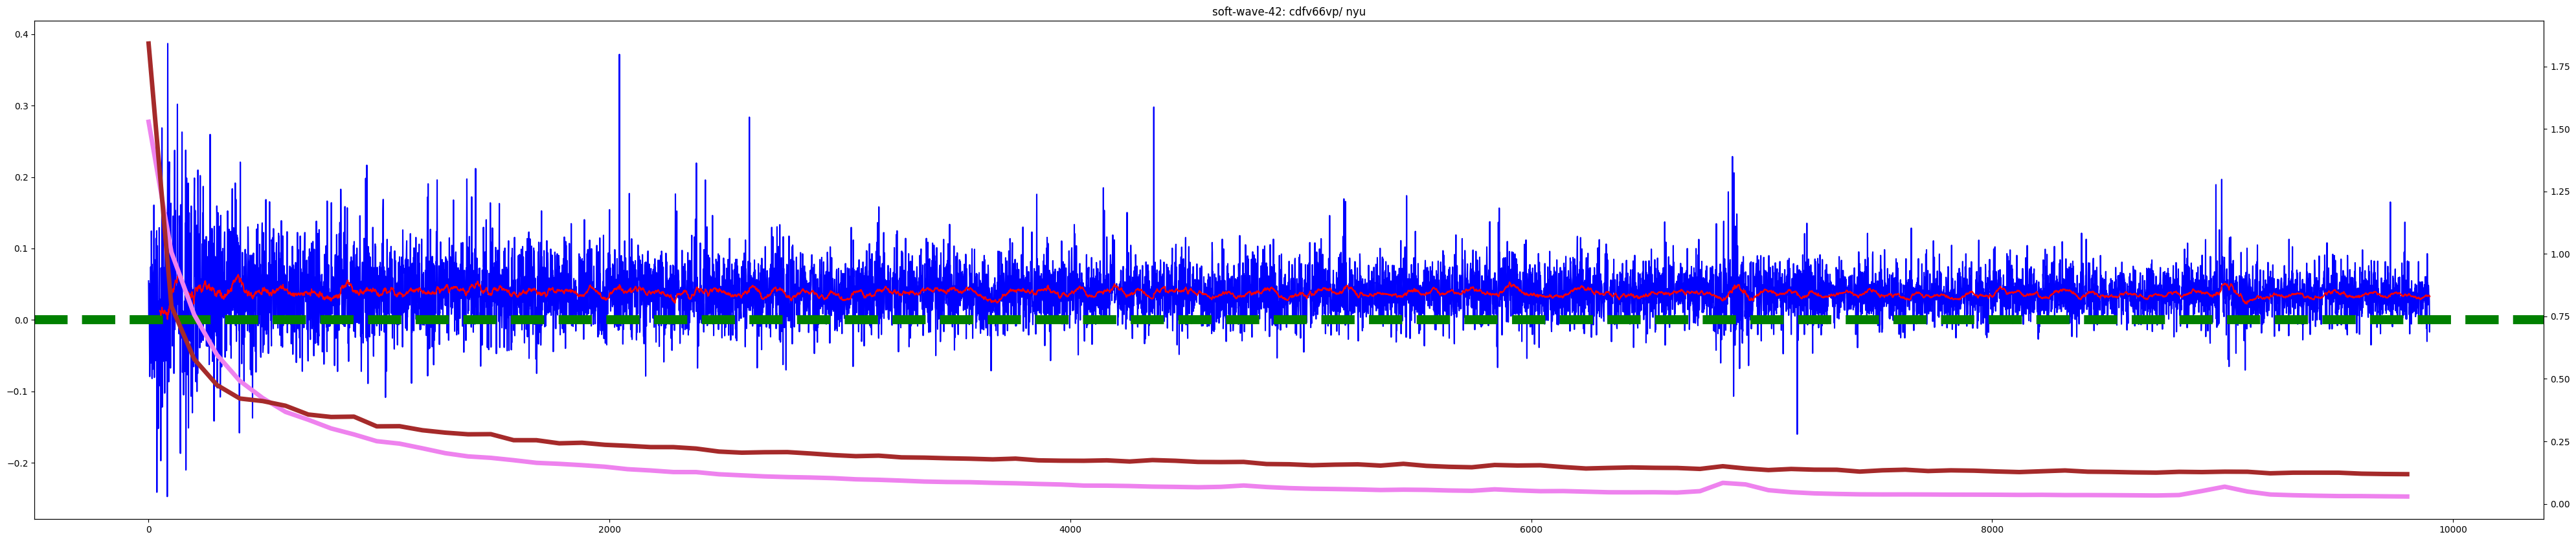

In [140]:
for wandb_id in wandb_ids:
    try:
        name, run_hist, gradients = load_run(wandb_id, 'nyu')
        num_epochs = gradients.shape[0]
        num_batches = gradients.shape[1]
        num_steps = num_epochs*num_batches
        plt.figure(figsize=(50,10))
        plt.title(f'{name}: {wandb_id}/ nyu')
        plt.plot(gradients[:, :, 0, 1].flatten(), 'b')
        plt.axhline(0, 0, 1, color='g', linestyle='--', linewidth=10)
        # plt.ylim(-1,1)
        pd.Series(gradients[:, :, 0,1].flatten()).rolling(50).mean().plot(color='r')
        plt.twinx()
        plt.plot(np.arange(0,num_steps, num_steps/num_epochs), run_hist['losses.train.segmentation'].dropna(), color='violet', linewidth=5)
        plt.plot(np.arange(0,num_steps, num_steps/num_epochs), run_hist['losses.train.depth'].dropna(), color='brown', linewidth=5)
        # plt.ylim(-1, 1)
    except FileNotFoundError:
        print(f"Gradient file for run {wandb_id} not found")

frew28mz  frew28mz.seg  frew28mz.depth  frjdq2uw  \
frew28mz        1.000000      0.130940        0.043075  0.050860   
frew28mz.seg    0.130940      1.000000        0.961997  0.222167   
frew28mz.depth  0.043075      0.961997        1.000000  0.256247   
frjdq2uw        0.050860      0.222167        0.256247  1.000000   
frjdq2uw.seg    0.024146      0.988419        0.968372  0.241059   
frjdq2uw.depth  0.017163      0.941053        0.994100  0.249786   
cdfv66vp        0.045892      0.140718        0.132725 -0.051530   
cdfv66vp.seg    0.004754      0.977751        0.961012  0.250458   
cdfv66vp.depth  0.006401      0.945700        0.993399  0.271304   

                frjdq2uw.seg  frjdq2uw.depth  cdfv66vp  cdfv66vp.seg  \
frew28mz            0.024146        0.017163  0.045892      0.004754   
frew28mz.seg        0.988419        0.941053  0.140718      0.977751   
frew28mz.depth      0.968372        0.994100  0.132725      0.961012   
frjdq2uw            0.241059        0.249786 -0.051530      0.250458   
frjdq2uw.seg        1.000000        0.953275  0.134547      0.993850   
frjdq2uw.depth      0.953275        1.000000  0.125481      0.944787   
cdfv66vp            0.134547        0.125481  1.000000      0.128169   
cdfv66vp.seg        0.993850        0.944787  0.128169      1.000000   
cdfv66vp.depth      0.958312        0.995691  0.119961      0.952750   

                cdfv66vp.depth  
frew28mz              0.006401  
frew28mz.seg          0.945700  
frew28mz.depth        0.993399  
frjdq2uw              0.271304  
frjdq2uw.seg          0.958312  
frjdq2uw.depth        0.995691  
cdfv66vp              0.119961  
cdfv66vp.seg          0.952750  
cdfv66vp.depth        1.000000

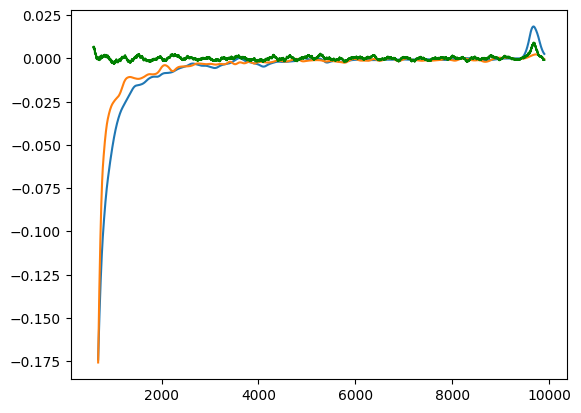

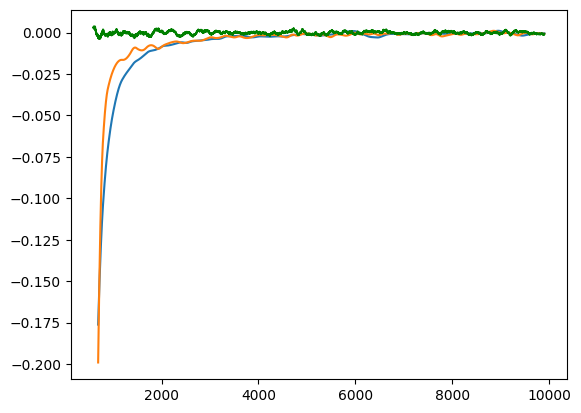

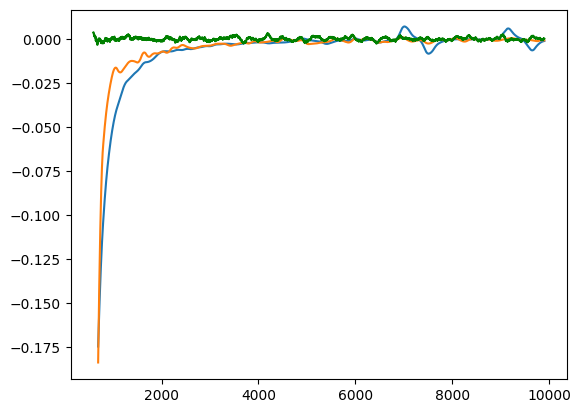

In [145]:
gradient_df = pd.DataFrame()
loss_df = pd.DataFrame()
df = pd.DataFrame()
for wandb_id in wandb_ids:
    name, run_hist, gradients = load_run(wandb_id, 'nyu')
    
    # Gradients and losses as dataframe
    num_epochs = gradients.shape[0]
    num_batch = gradients.shape[1]
    gradient_df = pd.DataFrame()
    loss_df = pd.DataFrame()
    gradient_df[wandb_id] = pd.Series(gradients[:, :, 0, 1].flatten())
    loss_df[f'{wandb_id}.seg'] = run_hist['losses.train.segmentation'].dropna()
    loss_df[f'{wandb_id}.depth'] = run_hist['losses.train.depth'].dropna()
    loss_df = loss_df.reset_index().drop('index', axis=1)
    loss_df.index = np.arange(num_batch-1, num_epochs*num_batch, num_batch)
    
    #Put into one dataframe, with interpolated values for loss
    df = pd.concat([df, gradient_df, loss_df], axis=1)
    df = df.interpolate('linear')
            
    # Plot first order difference of train loss for each task
    # np.interp(np.arange())
    plt.figure()
    plt.plot(df[f'{wandb_id}.seg'].dropna().rolling(5*num_batch).mean().diff(periods=num_batch))
    plt.plot(df[f'{wandb_id}.depth'].dropna().rolling(5*num_batch).mean().diff(periods=num_batch))
    # Plot mean cosine similarity per epoch 1st order difference
    plt.plot(df[wandb_id].rolling(5*num_batch).mean().diff(periods=num_batch), 'g')
    # plt.plot(gradients.mean(axis=1)[:, 0, 1], 'g')

    # Calculate r2 between first-order difference of loss and mean gradient
    # r2 = np.corrcoef(df[f'{wandb_id}.L'].dropna().rolling(2500).mean().diff(periods=num_batch).dropna(), df[wandb_id].rolling(2500).mean().diff(periods=num_batch).dropna() )
    # print(r2)

    # plt.title(f'{name}/{wandb_id}, r2: {float(r2[0, 1]):.3f}')
r2 = df.rolling(5*num_batch).mean().diff(periods=num_batch).corr()
r2

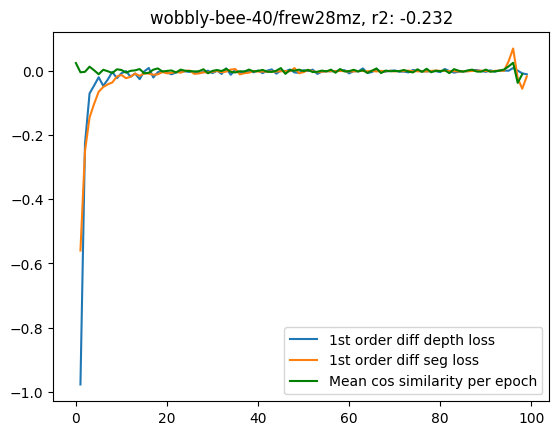

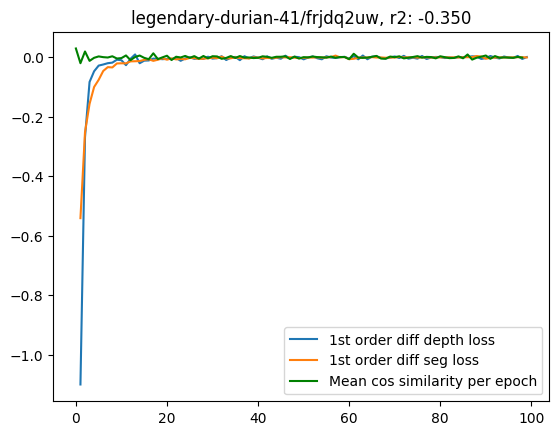

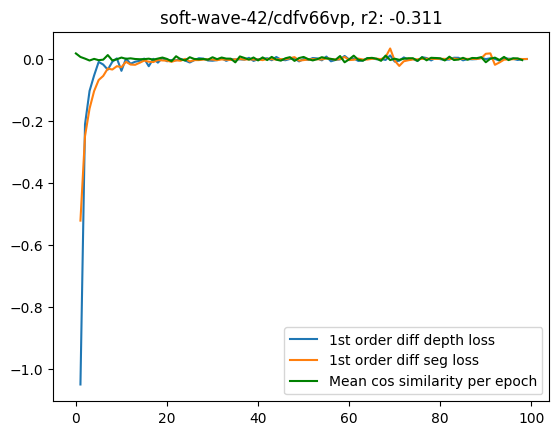

In [24]:
gradient_df = pd.DataFrame()
loss_df = pd.DataFrame()

for wandb_id in wandb_ids:
    try:
        name, run_hist, gradients = load_run(wandb_id, 'nyu')
        
        # Cos similarity and losses as dataframes/series
        gradient_df[wandb_id] = pd.Series(gradients[:, :, 0, 1].flatten())
        loss_df[f'{wandb_id}.segmentation'] = run_hist['losses.train.segmentation'].dropna()
        loss_df[f'{wandb_id}.depth'] = run_hist['losses.train.depth'].dropna()
        
        # Plot mean gradient per epoch and first order difference
        plt.figure()
        # plt.plot(run_hist['losses.train.depth'].dropna().reset_index().diff().iloc[:, 1], label='1st order diff depth loss')
        # plt.plot(run_hist['losses.train.segmentation'].dropna().reset_index().diff().iloc[:, 1], label='1st order diff seg loss')
        # plt.plot(run_hist['losses.train.depth'].dropna().reset_index().diff().iloc[:, 1], label='1st order diff depth loss')
        # plt.plot(run_hist['losses.train.segmentation'].dropna().reset_index().diff().iloc[:, 1], label='1st order diff seg loss')
        plt.plot(np.diff(gradients.mean(axis=1)[:, 0, 1]), 'g', label='Mean cos similarity per epoch')
        r2 = np.corrcoef(run_hist['losses.train.segmentation'].dropna().reset_index().diff().iloc[1:, 1], np.diff(gradients.mean(axis=1)[:, 0, 1]))
        plt.title(f'{name}/{wandb_id}, r2: {float(r2[0, 1]):.3f}')
        plt.legend()
    except FileNotFoundError as e:
        print(e)
        print(f"Gradient file for run {wandb_id} does not exist")

# Cityscape runs
3 runs with resnet18, default optimizer config. Each run different seed.
Cosine similarity wrt to segmentation and depth estimation

In [153]:
wandb_project = 'the_patpat/LibMTL-examples_cityscapes'
# wandb_ids = [run.id for run in api.runs(wandb_project)]
wandb_ids = ['09tl9tut', 'm7nq8itj', 'ojt407du']

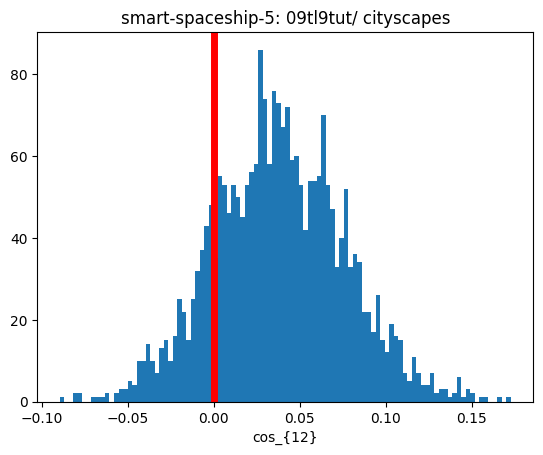

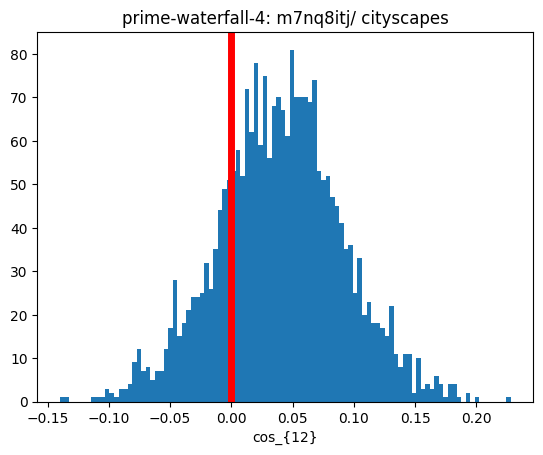

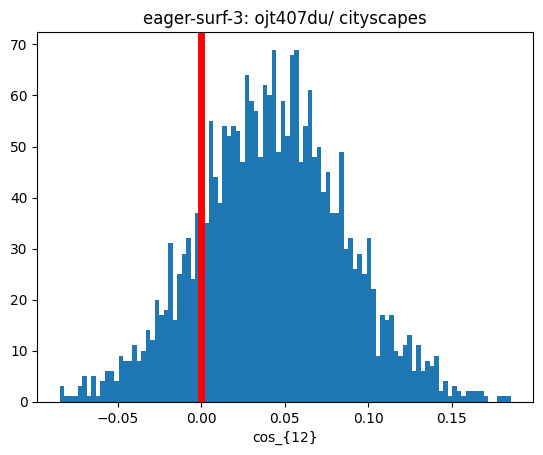

In [154]:
for wandb_id in wandb_ids:
    try:
        name, run, gradients = load_run(wandb_id, 'cityscapes')
        plt.figure()
        plt.hist(gradients[:, :, 0, 1].flatten(), bins=100)
        plt.title(f'{name}: {wandb_id}/ cityscapes')
        plt.xlabel('cos_{12}')
        plt.axvline(0, 0, 1, color='r', linewidth=5)
    except FileNotFoundError:
        print(f'gradient file for {wandb_id} not found')

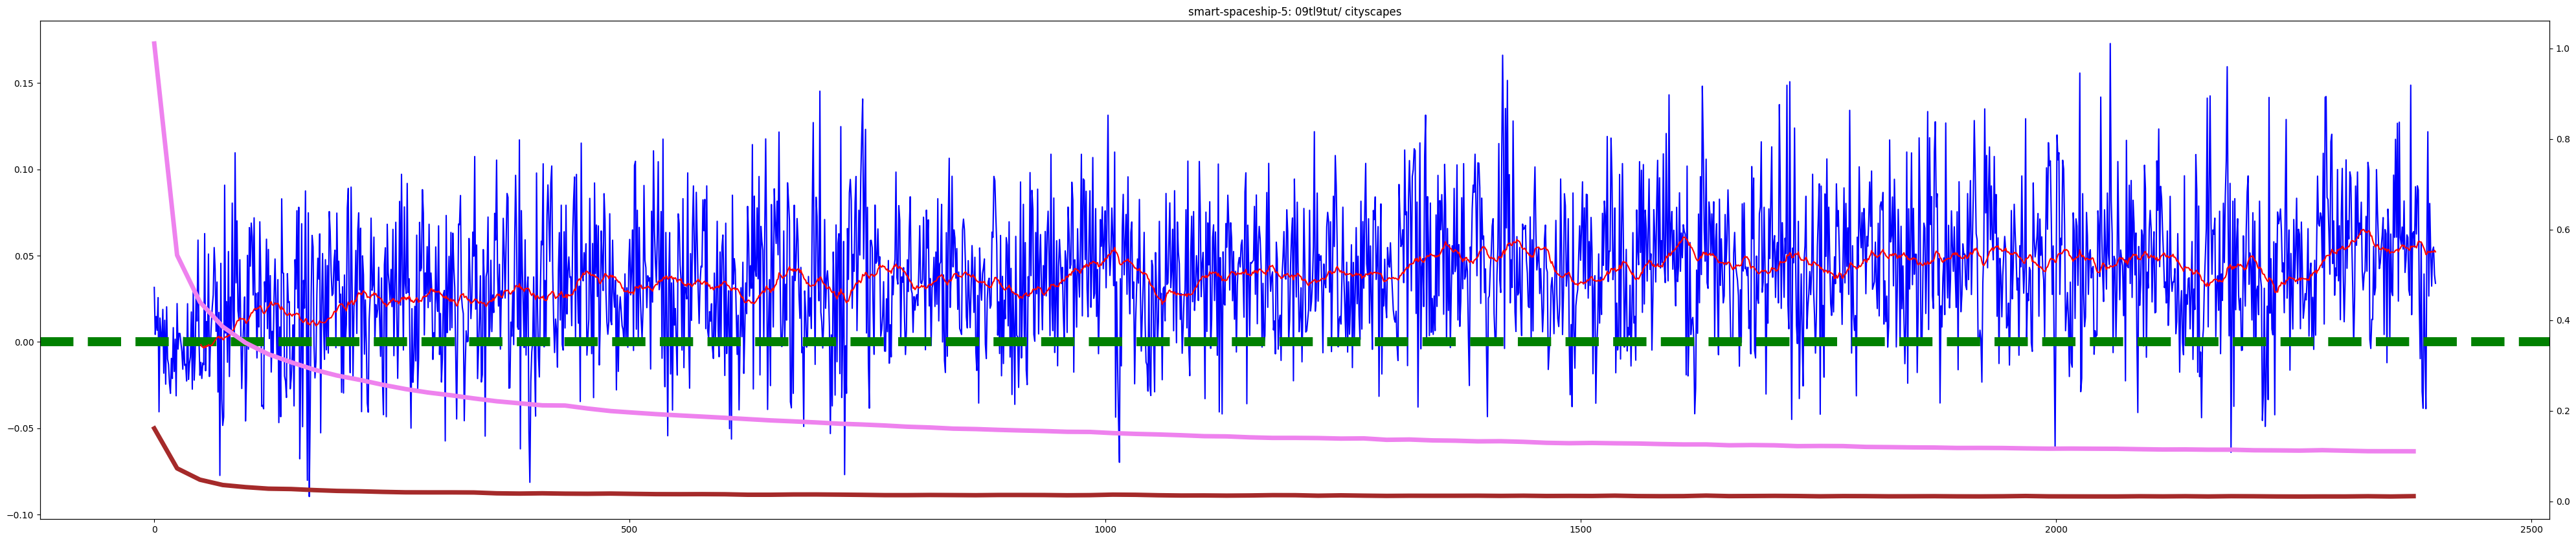

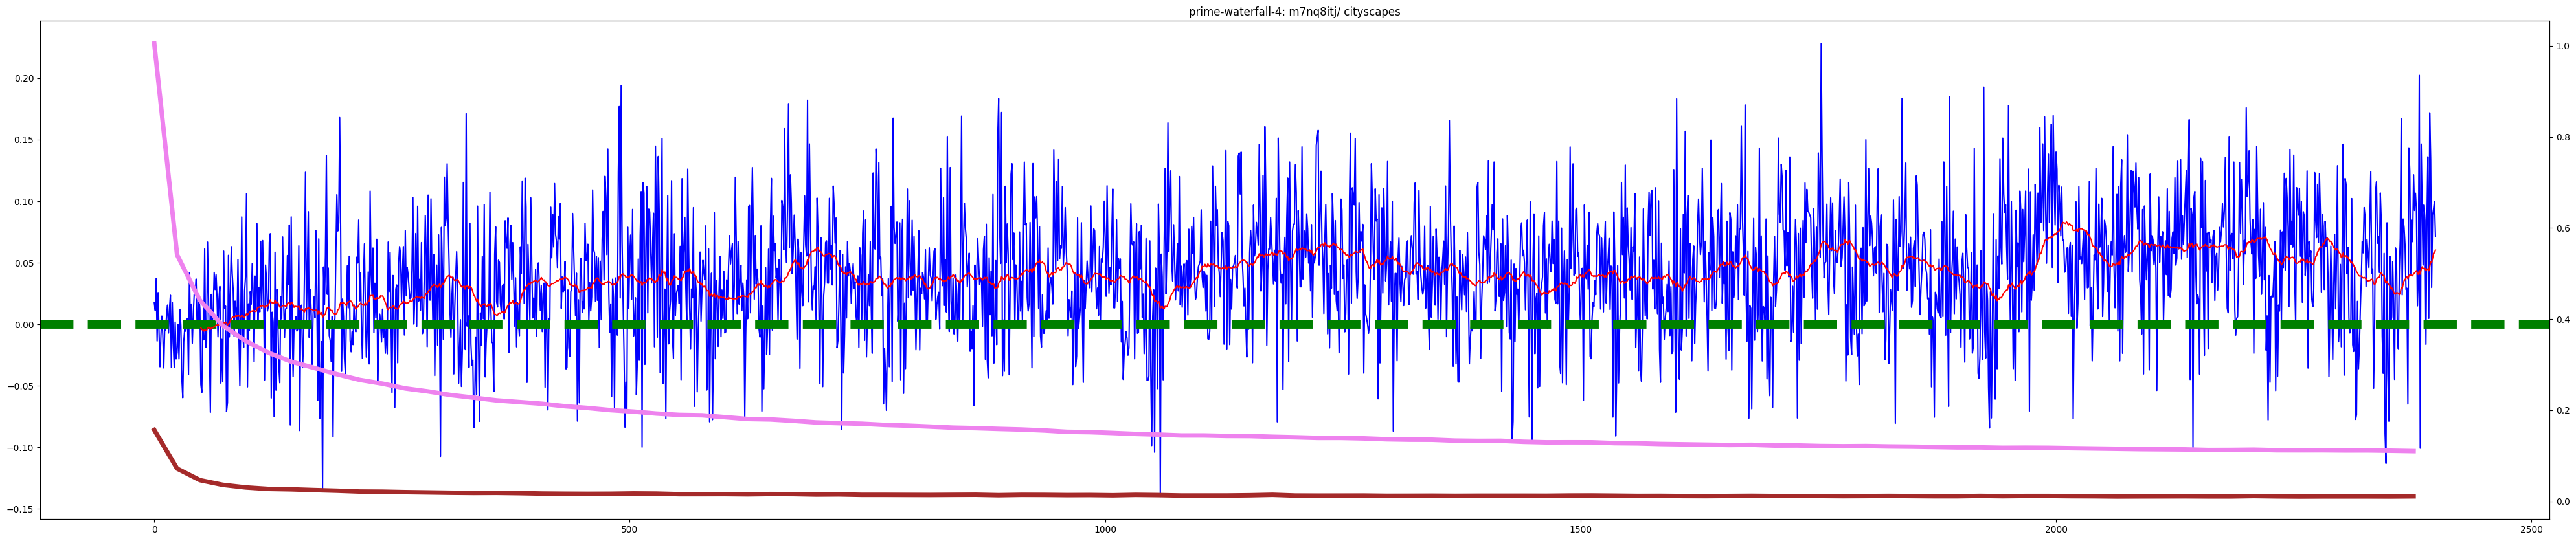

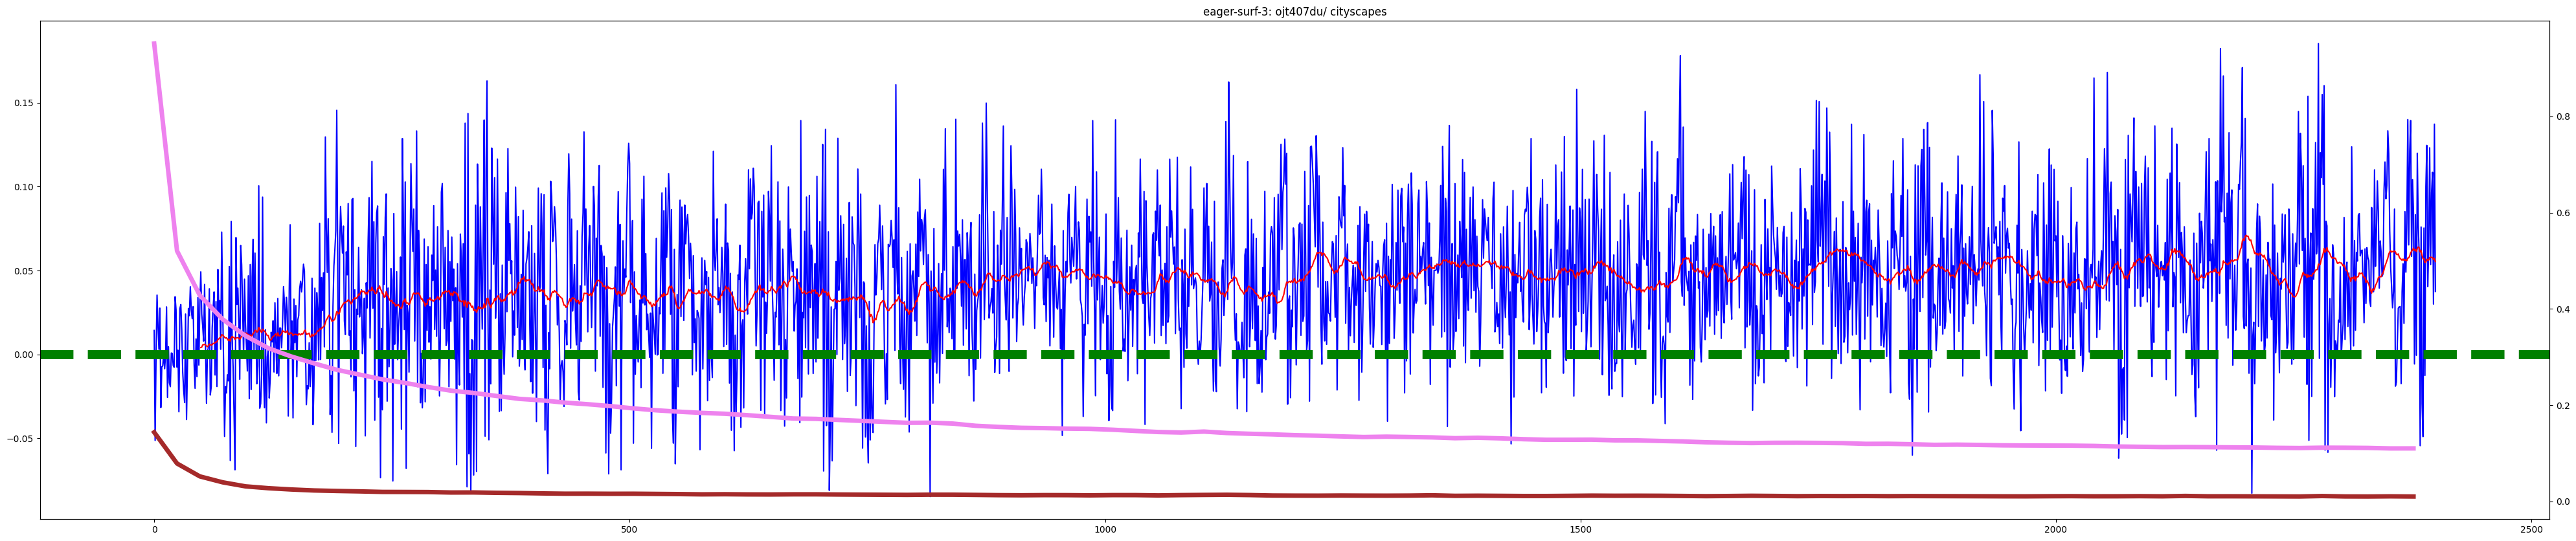

In [155]:
for wandb_id in wandb_ids:
    try:
        name, run_hist, gradients = load_run(wandb_id, 'cityscapes')
        num_epochs = gradients.shape[0]
        num_batches = gradients.shape[1]
        num_steps = num_epochs*num_batches
        plt.figure(figsize=(50,10))
        plt.title(f'{name}: {wandb_id}/ cityscapes')
        plt.plot(gradients[:, :, 0, 1].flatten(), 'b')
        plt.axhline(0, 0, 1, color='g', linestyle='--', linewidth=10)
        # plt.ylim(-1,1)
        pd.Series(gradients[:, :, 0,1].flatten()).rolling(50).mean().plot(color='r')
        plt.twinx()
        plt.plot(np.arange(0,num_steps, num_steps/num_epochs), run_hist['losses.train.segmentation'].dropna(), color='violet', linewidth=5)
        plt.plot(np.arange(0,num_steps, num_steps/num_epochs), run_hist['losses.train.depth'].dropna(), color='brown', linewidth=5)
        # plt.ylim(-1, 1)
    except FileNotFoundError:
        print(f"Gradient file for run {wandb_id} not found")

09tl9tut  09tl9tut.seg  09tl9tut.depth  m7nq8itj  \
09tl9tut        1.000000     -0.138568       -0.145553 -0.008882   
09tl9tut.seg   -0.138568      1.000000        0.979206 -0.090748   
09tl9tut.depth -0.145553      0.979206        1.000000 -0.075642   
m7nq8itj       -0.008882     -0.090748       -0.075642  1.000000   
m7nq8itj.seg   -0.139372      0.999585        0.977498 -0.088881   
m7nq8itj.depth -0.143594      0.977392        0.997116 -0.067049   
ojt407du        0.069570     -0.179375       -0.148985  0.127879   
ojt407du.seg   -0.136210      0.999133        0.974337 -0.093599   
ojt407du.depth -0.134672      0.977386        0.988730 -0.075647   

                m7nq8itj.seg  m7nq8itj.depth  ojt407du  ojt407du.seg  \
09tl9tut           -0.139372       -0.143594  0.069570     -0.136210   
09tl9tut.seg        0.999585        0.977392 -0.179375      0.999133   
09tl9tut.depth      0.977498        0.997116 -0.148985      0.974337   
m7nq8itj           -0.088881       -0.067049  0.127879     -0.093599   
m7nq8itj.seg        1.000000        0.976411 -0.179806      0.999393   
m7nq8itj.depth      0.976411        1.000000 -0.152669      0.973115   
ojt407du           -0.179806       -0.152669  1.000000     -0.182141   
ojt407du.seg        0.999393        0.973115 -0.182141      1.000000   
ojt407du.depth      0.976231        0.989413 -0.177835      0.974929   

                ojt407du.depth  
09tl9tut             -0.134672  
09tl9tut.seg          0.977386  
09tl9tut.depth        0.988730  
m7nq8itj             -0.075647  
m7nq8itj.seg          0.976231  
m7nq8itj.depth        0.989413  
ojt407du             -0.177835  
ojt407du.seg          0.974929  
ojt407du.depth        1.000000

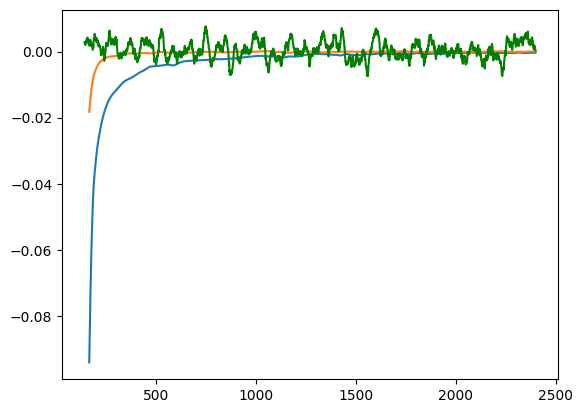

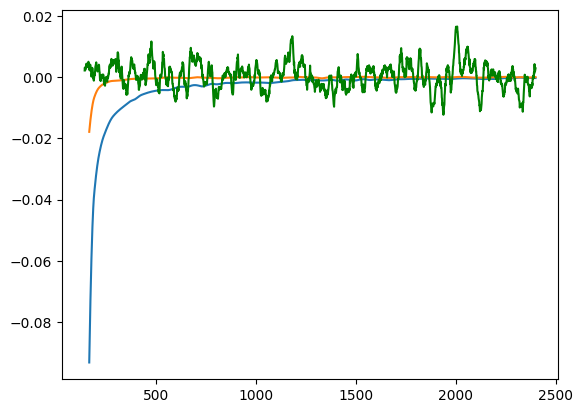

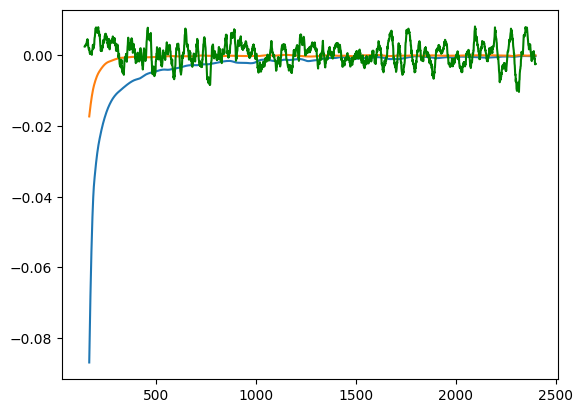

In [156]:
gradient_df = pd.DataFrame()
loss_df = pd.DataFrame()
df = pd.DataFrame()
for wandb_id in wandb_ids:
    name, run_hist, gradients = load_run(wandb_id, 'cityscapes')
    
    # Gradients and losses as dataframe
    num_epochs = gradients.shape[0]
    num_batch = gradients.shape[1]
    gradient_df = pd.DataFrame()
    loss_df = pd.DataFrame()
    gradient_df[wandb_id] = pd.Series(gradients[:, :, 0, 1].flatten())
    loss_df[f'{wandb_id}.seg'] = run_hist['losses.train.segmentation'].dropna()
    loss_df[f'{wandb_id}.depth'] = run_hist['losses.train.depth'].dropna()
    loss_df = loss_df.reset_index().drop('index', axis=1)
    loss_df.index = np.arange(num_batch-1, num_epochs*num_batch, num_batch)
    
    #Put into one dataframe, with interpolated values for loss
    df = pd.concat([df, gradient_df, loss_df], axis=1)
    df = df.interpolate('linear')
            
    # Plot first order difference of train loss for each task
    # np.interp(np.arange())
    plt.figure()
    plt.plot(df[f'{wandb_id}.seg'].dropna().rolling(5*num_batch).mean().diff(periods=num_batch))
    plt.plot(df[f'{wandb_id}.depth'].dropna().rolling(5*num_batch).mean().diff(periods=num_batch))
    # Plot mean cosine similarity per epoch 1st order difference
    plt.plot(df[wandb_id].rolling(5*num_batch).mean().diff(periods=num_batch), 'g')
    # plt.plot(gradients.mean(axis=1)[:, 0, 1], 'g')

    # Calculate r2 between first-order difference of loss and mean gradient
    # r2 = np.corrcoef(df[f'{wandb_id}.L'].dropna().rolling(2500).mean().diff(periods=num_batch).dropna(), df[wandb_id].rolling(2500).mean().diff(periods=num_batch).dropna() )
    # print(r2)

    # plt.title(f'{name}/{wandb_id}, r2: {float(r2[0, 1]):.3f}')
r2 = df.rolling(5*num_batch).mean().diff(periods=num_batch).corr()
r2

[Errno 2] No such file or directory: 'examples/cityscapes/gradients_ite28wo6.npz'
Gradient file for run ite28wo6 does not exist
[Errno 2] No such file or directory: 'examples/cityscapes/gradients_sj7jieq4.npz'
Gradient file for run sj7jieq4 does not exist


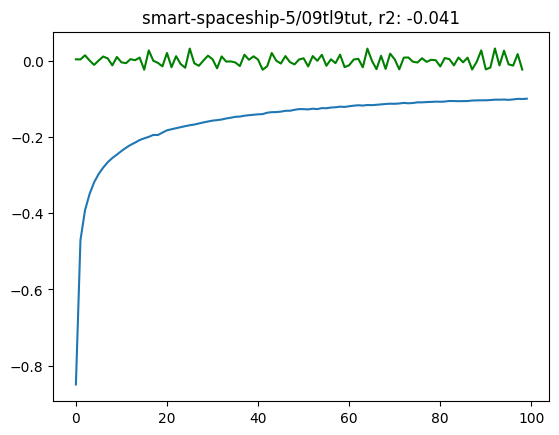

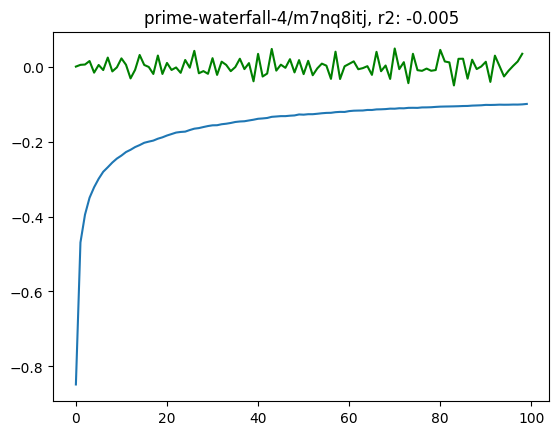

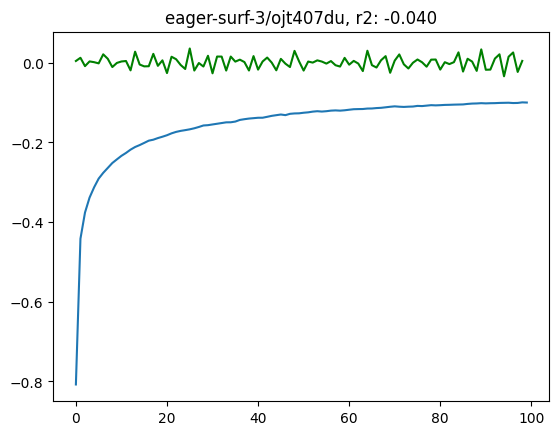

In [53]:
gradient_df = pd.DataFrame()
loss_df = pd.DataFrame()

for wandb_id in wandb_ids:
    try:
        name, run_hist, gradients = load_run(wandb_id, 'cityscapes')
        gradient_df[wandb_id] = pd.Series(gradients[:, :, 0, 1].flatten())
        loss_df[f'{wandb_id}.segmentation'] = run_hist['losses.train.segmentation'].dropna()
        loss_df[f'{wandb_id}.depth'] = run_hist['losses.train.depth'].dropna()
        # plt.plot(gradients.mean(axis=1)[:, 0, 1], 'bo')
        plt.figure()
        # plt.plot(run_hist['losses.train.segmentation'].dropna().reset_index()['losses.train.segmentation'].diff())
        # plt.plot(run_hist['losses.train.depth'].dropna().reset_index()['losses.train.depth'].diff())
        plt.plot((run_hist['losses.train.depth'].dropna() - run_hist['losses.train.segmentation'].dropna()).reset_index().iloc[:, 1])
        plt.plot(np.diff(gradients.mean(axis=1)[:, 0, 1]), 'g')
        r2 = np.corrcoef(run_hist['losses.train.segmentation'].dropna().reset_index()['losses.train.segmentation'].diff().iloc[1:], np.diff(gradients.mean(axis=1)[:, 0, 1]))
        plt.title(f'{name}/{wandb_id}, r2: {float(r2[0, 1]):.3f}')
    except FileNotFoundError as e:
        print(e)
        print(f"Gradient file for run {wandb_id} does not exist")